In [3]:
import geopandas as gpd
from shapely.geometry import LineString, MultiPoint
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Sampling points of street linestrings

##### Explanation: 
The below code provides two approaches of converting multistrings to points by performing sampling every 50m on lines. If a line is <50m, then the code samples a centroid of that line to ensure that each line has at least one point. 

R furher provides a function st_line_sample, where density can be specified as an argument for sampling distance between points; however this approach appears to be slower. 

## 1st approach (slower)

In [4]:
streets_sf = gpd.read_file("data_collection/street_data/netherlands_streets_reproject_epsg28892.gpkg")
streets_sf

,w_id,highway,name,geometry
0,2161182,footway,Jutfaseweg,"LINESTRING (136345.529 453378.539, 136400.663 ..."
1,2952999,footway,Pieter Bernagiestraat,"LINESTRING (136531.182 454413.677, 136554.169 ..."
2,2953564,cycleway,Timorkade,"LINESTRING (135589.322 455838.819, 135588.092 ..."
3,2956818,pedestrian,Alkhof,"LINESTRING (137023.428 454629.211, 137028.052 ..."
4,2976724,pedestrian,Twijnstraat aan de Werf,"LINESTRING (136925.889 454877.017, 136924.950 ..."
...,...,...,...,...
1118027,1175423565,cycleway,Oppenhuizerweg,"LINESTRING (174301.040 559854.797, 174355.311 ..."
1118028,1175423566,secondary,Oppenhuizerweg,"LINESTRING (174324.739 559837.820, 174320.608 ..."
1118029,1175423567,secondary,Oppenhuizerweg,"LINESTRING (174324.739 559837.820, 174382.110 ..."
1118030,1175423568,secondary,Oppenhuizerweg,"LINESTRING (174405.273 559726.280, 174413.774 ..."


In [ ]:
length_meters = streets_sf.length
length_numeric = length_meters.astype(float)

sampled_points = []

for i in range(len(streets_sf)):
    print(f"\rProcessing feature {i+1} of {len(length_numeric)}", end="", flush=True)
    
    if length_numeric[i] < 50:
        point = streets_sf.geometry[i].centroid
        sampled_points.append(point)
    else:
        line = streets_sf.geometry[i]
        points = [point for distance in range(0, int(line.length), 50) for point in [line.interpolate(distance)]]
        sampled_points.extend(points)

sampled_points = gpd.GeoSeries(sampled_points)
sampled_points = gpd.GeoDataFrame(geometry=sampled_points)

print(sampled_points)
print(sampled_points.dtypes)

Processing feature 37981 of 144757

 ## 2nd approach (faster)

In [11]:
# streets_sf = gpd.read_file("C:/Users/Ondrej/2.5D-GreenViewIndex-Netherlands/Data collection/street_data/netherlands_streets.gpkg")
# streets_sf = streets_sf.to_crs(epsg=28992)

length_meters = streets_sf.length
length_numeric = length_meters.astype(float)

sampled_points = []

def process_feature(i):
    if length_numeric[i] < 50:
        point = streets_sf.geometry[i].centroid
        sampled_points.append(point)
    else:
        line = streets_sf.geometry[i]
        # distances = np.arange(0, int(line.length), 50)
        num_points = int(line.length / 50) + 1  # use this instead of distances to ensure more uniform sampling
        distances = np.linspace(0, line.length, num=num_points)
        points = [line.interpolate(distance) for distance in distances]
        sampled_points.extend(points)

print("Processing features...")
_ = [process_feature(i) for i in range(len(streets_sf))]

sampled_points = gpd.GeoSeries(sampled_points)
sampled_points = gpd.GeoDataFrame(geometry=sampled_points)

print(sampled_points)
print(sampled_points.dtypes)

Processing features...
                              geometry
0        POINT (136345.529 453378.539)
1        POINT (136400.663 453352.632)
2        POINT (136531.182 454413.677)
3        POINT (136585.248 454386.613)
4        POINT (136642.237 454367.379)
...                                ...
4063062  POINT (174324.739 559837.820)
4063063  POINT (174382.110 559758.304)
4063064  POINT (174405.273 559726.280)
4063065  POINT (174435.298 559678.281)
4063066  POINT (174555.346 559685.420)

[4063067 rows x 1 columns]
geometry    geometry
dtype: object


In [7]:
sampled_points.to_file("data_collection/street_data/sampled_points_ned.gpkg", driver="GPKG")
print(f"Output saved to {sampled_points_ned}")

NameError: name 'sampled_points_ned' is not defined

## Visualise the points

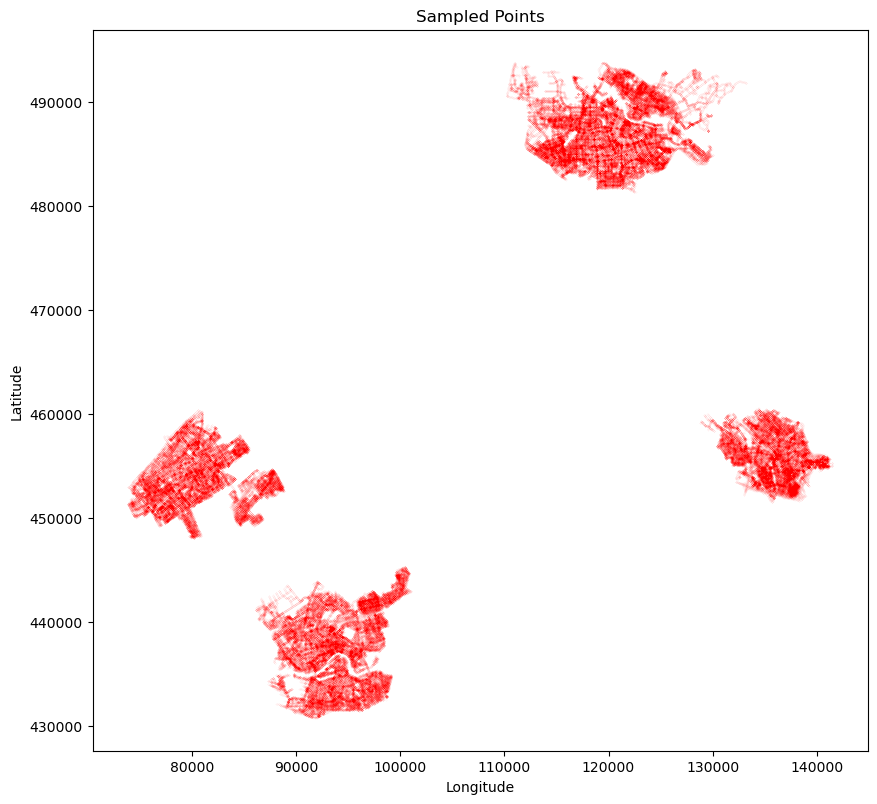

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
sampled_points.plot(ax=ax, color='red', markersize=1/10000)

ax.set_title('Sampled Points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()